<a href="https://colab.research.google.com/github/jinglescode/demos/blob/master/my-journey-computer-vision/codes/CIFAR10_transferlearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, transforms, models

import matplotlib.pyplot as plt
import numpy as np
import time
import copy

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [0]:
use_pretrained = True
feature_extract = True
num_classes = 10

model_ft = models.resnet18(pretrained=use_pretrained)
set_parameter_requires_grad(model_ft, feature_extract)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, num_classes)
input_size = 224

model_ft = model_ft.to(device)

In [5]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [6]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

datasets_dict = {
    'train': datasets.CIFAR10(root='./temp', train=True, download=True, transform=data_transforms['train']),
    'val': datasets.CIFAR10(root='./temp', train=False, download=True, transform=data_transforms['val'])
}

dataloaders_dict = {
    'train': torch.utils.data.DataLoader(datasets_dict['train'], batch_size=64, shuffle=True),
    'val': torch.utils.data.DataLoader(datasets_dict['val'], batch_size=64, shuffle=True)
}

Files already downloaded and verified
Files already downloaded and verified


In [7]:
params_to_update = model_ft.parameters()
print("Params to learn:")
params_to_update = []
for name,param in model_ft.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 fc.weight
	 fc.bias


In [0]:
# optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

optimizer_ft = optim.Adam(params_to_update, lr=0.001)

In [0]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

In [0]:
# Train and evaluate
num_epochs = 5
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

In [35]:
# resnet18 = models.resnet18(pretrained=True)

# removed = list(resnet18.children())[:-1]
# resnet18 = torch.nn.Sequential(*removed)
# for p in resnet18.parameters():
#     p.requires_grad = False
# resnet18 = torch.nn.Sequential(resnet18, torch.nn.Linear(512,10))

# resnet18

resnet18 = models.resnet18(pretrained=True)

# modules=list(resnet18.children())[:-1]
# resnet18=nn.Sequential(*modules)
for p in resnet18.parameters():
    p.requires_grad = False

resnet18 = torch.nn.Sequential(resnet18, torch.nn.Linear(1000,10))

resnet18

Sequential(
  (0): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

In [0]:
def load_pretrain_model():

    pretrained_model = models.resnet18(pretrained=True)

    # for p in pretrained_model.parameters():
    #     p.requires_grad = False
    
    pretrained_model.fc = nn.Sequential(
        # nn.Dropout(0.5),
        nn.Linear(512, 10)
    )

    # pretrained_model = models.resnet152(pretrained=True)
    # model = torch.nn.Sequential(*(list(pretrained_model.children())[:-1])) #nn.Sequential(*list(pretrained_model.children())[:-1])

    # modules = list(model.children())[:-1]
    # model = nn.Sequential(*modules)
    # for p in model.parameters():
    #     p.requires_grad = False
    return pretrained_model

model = load_pretrain_model()

# model = torch.nn.Sequential(model, torch.nn.Linear(512,10))

model

trainer = Trainer(model)
trainer.fit(15, trainloader, testloader)




Starting training...
Epoch  1 in 50s || Train loss=1.030, acc=0.656 | Val loss=0.917, acc=0.705
Epoch  2 in 50s || Train loss=0.689, acc=0.773 | Val loss=0.670, acc=0.780
Epoch  3 in 50s || Train loss=0.550, acc=0.818 | Val loss=0.619, acc=0.794
Epoch  4 in 50s || Train loss=0.507, acc=0.833 | Val loss=0.600, acc=0.806
Epoch  5 in 50s || Train loss=0.375, acc=0.876 | Val loss=0.584, acc=0.810
Epoch  6 in 50s || Train loss=0.305, acc=0.899 | Val loss=0.641, acc=0.800
Epoch  7 in 50s || Train loss=0.268, acc=0.911 | Val loss=0.624, acc=0.811
Epoch  8 in 50s || Train loss=0.208, acc=0.931 | Val loss=0.702, acc=0.811


In [0]:
class ConvNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, 512)

        self.dropout = nn.Dropout(p=0.1)

        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters(), lr=0.001)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = F.relu(x)
        
        x = x.view(x.shape[0], -1)

        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        x = F.log_softmax(x, dim=1)
        
        return x

Starting training...
Epoch  1 in 17s || Train loss=1.470, acc=0.476 | Val loss=1.184, acc=0.579
Epoch  2 in 17s || Train loss=1.065, acc=0.621 | Val loss=1.023, acc=0.638
Epoch  3 in 17s || Train loss=0.898, acc=0.682 | Val loss=0.932, acc=0.678
Epoch  4 in 18s || Train loss=0.758, acc=0.733 | Val loss=0.907, acc=0.685
Epoch  5 in 17s || Train loss=0.610, acc=0.788 | Val loss=0.887, acc=0.705
Epoch  6 in 18s || Train loss=0.463, acc=0.840 | Val loss=0.993, acc=0.696
Epoch  7 in 17s || Train loss=0.325, acc=0.889 | Val loss=1.036, acc=0.700
Early Stop


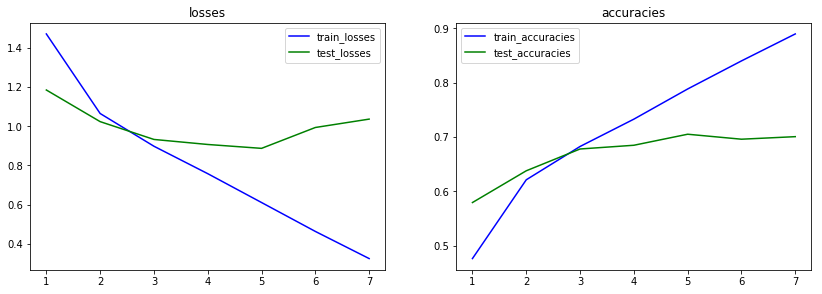

In [0]:
model = ConvNetwork()
trainer = Trainer(model)
trainer.fit(15, trainloader, testloader)

In [0]:
def visualise_weights(weights):
    chart_rows = weights.shape[0]
    chart_cols = weights.shape[1]
    counter = 1

    fig = plt.figure(figsize=(14, 14))
    for i in range(chart_rows):
        for j in range(chart_cols):
            ax1 = fig.add_subplot(chart_rows, chart_cols, counter)
            ax1.imshow(weights[i][j].detach().cpu().numpy(), cmap='gray')
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
            counter += 1
    plt.show()

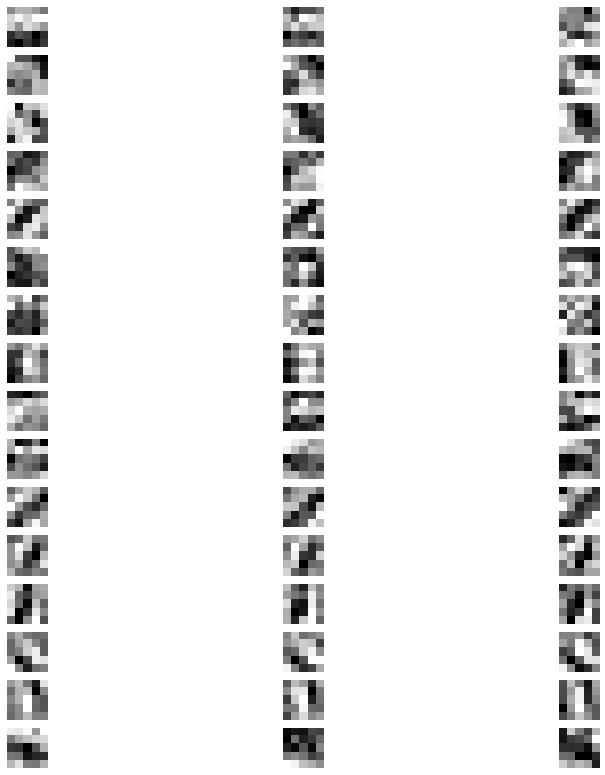

In [0]:
weights = model.conv1.weight
visualise_weights(weights)

In [0]:
class ConvNetwork2(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Sutskever, I., Hinton, G.E. and Krizhevsky, A., 2012. Imagenet classification with deep convolutional neural networks. Advances in neural information processing systems, pp.1097-1105.
        
        self.conv1 = nn.Conv2d(3, 48, kernel_size=11, stride=4, padding=5)
        self.conv2 = nn.Conv2d(48, 128, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv2d(128, 192, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(192, 192, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(192, 128, kernel_size=3, stride=1, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(512, 1024)
        self.fc2 = nn.Linear(1024, 1024)

        self.dropout = nn.Dropout(p=0.1)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.conv5(x)
        x = F.relu(x)
        
        x = x.view(x.shape[0], -1)

        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        x = F.log_softmax(x, dim=1)
        
        return x

Starting training...
Epoch  1 in 36s || Train loss=1.905, acc=0.290 | Val loss=1.449, acc=0.461
Epoch  2 in 23s || Train loss=1.324, acc=0.520 | Val loss=1.224, acc=0.560
Epoch  3 in 21s || Train loss=1.120, acc=0.602 | Val loss=1.150, acc=0.602
Epoch  4 in 22s || Train loss=0.962, acc=0.662 | Val loss=1.095, acc=0.621
Epoch  5 in 22s || Train loss=0.827, acc=0.710 | Val loss=1.072, acc=0.639
Epoch  6 in 21s || Train loss=0.706, acc=0.753 | Val loss=1.118, acc=0.643
Epoch  7 in 22s || Train loss=0.605, acc=0.789 | Val loss=1.181, acc=0.631
Early Stop


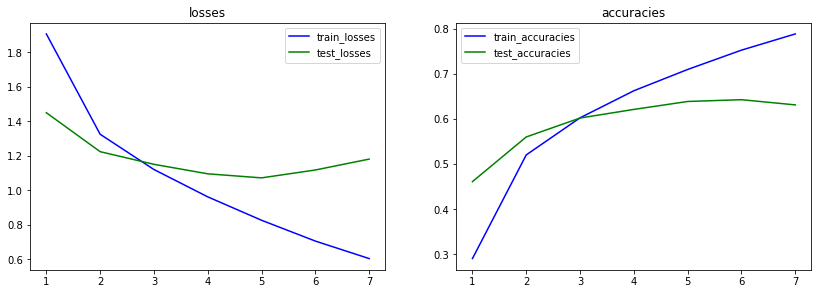

In [0]:
model2 = ConvNetwork2()
trainer2 = Trainer(model2)
trainer2.fit(15, trainloader, testloader)

Starting training...
Epoch  1 in 27s || Train loss=1.718, acc=0.354 | Val loss=1.339, acc=0.499
Epoch  2 in 39s || Train loss=1.311, acc=0.525 | Val loss=1.067, acc=0.618
Epoch  3 in 39s || Train loss=1.130, acc=0.597 | Val loss=0.954, acc=0.669
Epoch  4 in 39s || Train loss=1.018, acc=0.643 | Val loss=0.898, acc=0.688
Epoch  5 in 39s || Train loss=0.941, acc=0.672 | Val loss=0.861, acc=0.702
Epoch  6 in 39s || Train loss=0.881, acc=0.695 | Val loss=0.748, acc=0.739
Epoch  7 in 39s || Train loss=0.826, acc=0.713 | Val loss=0.735, acc=0.744
Epoch  8 in 40s || Train loss=0.795, acc=0.727 | Val loss=0.694, acc=0.765
Epoch  9 in 39s || Train loss=0.761, acc=0.738 | Val loss=0.697, acc=0.764
Epoch 10 in 34s || Train loss=0.729, acc=0.751 | Val loss=0.730, acc=0.750
Early Stop


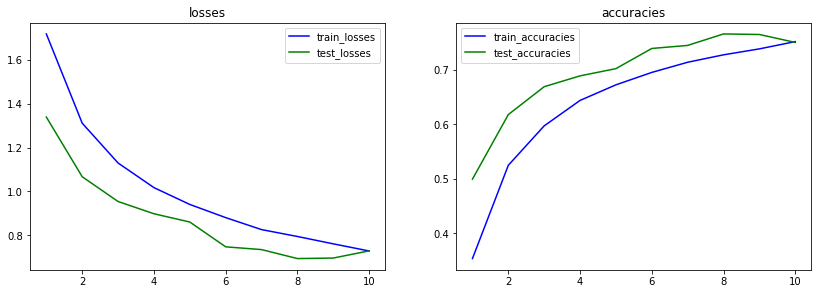

In [0]:
class ConvNetwork3(nn.Module):
    def __init__(self):
        super().__init__()
                
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)

        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(2048, 128)
        self.fc2 = nn.Linear(128, 10)

        self.dropout2 = nn.Dropout(p=0.2)
        self.dropout3 = nn.Dropout(p=0.3)
        self.dropout4 = nn.Dropout(p=0.4)
        self.dropout5 = nn.Dropout(p=0.5)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout2(x)

        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout3(x)

        x = self.conv5(x)
        x = F.relu(x)
        x = self.conv6(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout4(x)
        
        x = x.view(x.shape[0], -1)

        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout5(x)
        x = self.fc2(x)
        
        x = F.log_softmax(x, dim=1)
        
        return x

model3 = ConvNetwork3()
trainer3 = Trainer(model3)
trainer3.fit(400, trainloader, testloader)

Starting training...
Epoch  1 in 24s || Train loss=1.738, acc=0.354 | Val loss=1.310, acc=0.514
Epoch  2 in 24s || Train loss=1.329, acc=0.519 | Val loss=1.130, acc=0.590
Epoch  3 in 24s || Train loss=1.149, acc=0.590 | Val loss=0.996, acc=0.646
Epoch  4 in 24s || Train loss=1.028, acc=0.639 | Val loss=0.891, acc=0.683
Epoch  5 in 24s || Train loss=0.948, acc=0.669 | Val loss=0.810, acc=0.718
Epoch  6 in 23s || Train loss=0.884, acc=0.695 | Val loss=0.788, acc=0.723
Epoch  7 in 24s || Train loss=0.833, acc=0.711 | Val loss=0.783, acc=0.727
Epoch  8 in 31s || Train loss=0.791, acc=0.727 | Val loss=0.702, acc=0.756
Epoch  9 in 41s || Train loss=0.760, acc=0.739 | Val loss=0.679, acc=0.767
Epoch 10 in 40s || Train loss=0.732, acc=0.749 | Val loss=0.687, acc=0.759
Epoch 11 in 41s || Train loss=0.710, acc=0.757 | Val loss=0.665, acc=0.770
Epoch 12 in 40s || Train loss=0.691, acc=0.762 | Val loss=0.653, acc=0.775
Epoch 13 in 40s || Train loss=0.670, acc=0.771 | Val loss=0.627, acc=0.786
Epoc

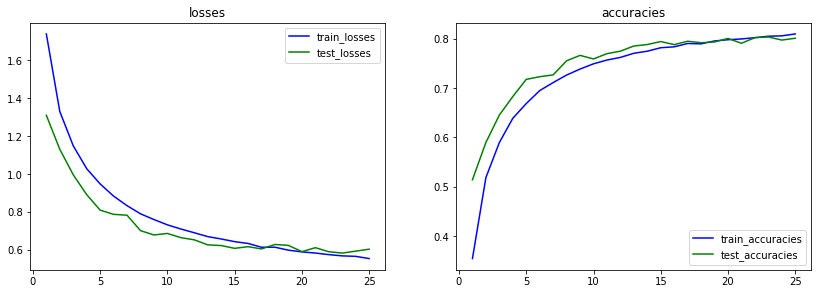

In [0]:
model4 = ConvNetwork3()
trainer4 = Trainer(model4)
trainer4.fit(400, trainloader, testloader, early_stopping=5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


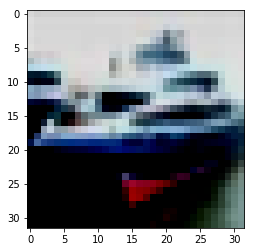

8 ship


In [0]:
data, target = testloader.dataset[1]
display_data(data, target)

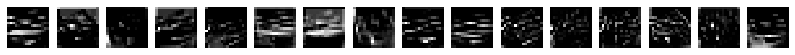

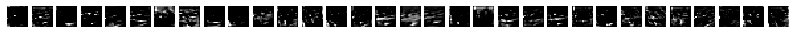

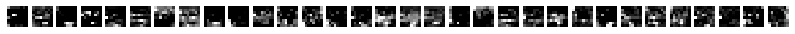

In [0]:
x = data.unsqueeze(0)
x = x.cuda()
x = Variable(x)

x = model.conv1(x)
x = F.relu(x)
visualise_weights(x)

x = model.conv2(x)
x = F.relu(x)
visualise_weights(x)

x = model.pool(x)
visualise_weights(x)